# Factor potentials

## Objectives and takeaways

1. Introduce the notion of a new building block: the factor potential.
2. Provide a case study on how a factor potential can be used in a model.

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. For example, in the coal disasters study in notebook 1b, we may want to impose the constraint that  the difference between the early and late means be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004) [1]. Bayesian hierarchical notation doesn't accomodate these potentials.

Note that in the future, factor potentials will be key in studying undirected [probabilistic graphical models](https://en.wikipedia.org/wiki/Graphical_model), which can in some cases be built from *factor graphs* (= products of factor potentials).  Thus getting familiar with the concept will also help us in the future.

## Case study 'face detection'

We will write a detector of faces from facial features: eyes, nose and mouth.  One of the ways this can be done is to have a classifier for each feature and if a candidate set is identified, ensure that the features are in a configuration that is compatible with a face.

While each facial feature will be identified via a standard approach, where it's potential position $(x,y)$ predicts the values of the pixels inside the feature region (for eye, 4x4 pixels, for mouth 1x7 pixels, etc.), the correct configuration constraints are enforced via potentials.

In [1]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data
We build two 'faces' and one 'non-face', the first face is the prototype symmetric face while the second face is slightly rotated clockwise.  The non-face has the requisite features but in wrong locations.  All matrices are on a grid of 9x9 pixels.

In [2]:
face = np.vstack([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])

face.shape

(9, 9)

In [3]:
face2 = np.vstack([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])

face2.shape

(9, 9)

In [4]:
not_face = np.vstack([
    [0, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])

not_face.shape

(9, 9)

### Feature detectors
Primitive templates for eyes, nose and mouth follow.  Each value corresponds to the probability of a pixel being switched on (=1) under the assumption that the top left pixel is the start of the feature.

In [5]:
# our fixed "convolutional filters"

eye_mask = np.array([
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.9, 0.9, 0.1],
    [0.1, 0.9, 0.9, 0.1],
    [0.1, 0.1, 0.1, 0.1]])

nose_mask = np.array([
    [0.1, 0.9, 0.1],
    [0.9, 0.9, 0.9]])

mouth_mask = np.array([
    [0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1]
])

### The model
The full model is written below.  Note that we sample pixel indices from the set of possible top-left pixes of each feature.  For the face, this is $6 \times 6$, since the template itself is $4\times 4$.  We then compute $(x,y)$ coordinates from the index and use those to match the template to the processed image pixel by pixel.  The nose matches a 2x3 mask as shown above.

The diagram of the entire model is:

![Face detector model](images/face_detector_diagram.png)

If we look at the 'faces' that have been artistically designed above and take into account the model structure, the following shows what regions are detected by each mask and what role the  factor potentials have in spatially relating the different features.

![Face features and potentials](images/face_features_potentials.png)

### Exercises

The model outputs the feature positions as indices into the pixel arraand also the negative sum of all the potentials (if active), which we call the tension.  The same function is supplied later so solutions can be tested manually if desired.  The tension should be low for actual faces that conform to model expectation and high for non-faces.

The model below is set up to process the uncommented dataset each of the datasets.

1. Study the mode structure.
2. Run the model for the face dataset.  Observe the posterior marginals.
3. Uncomment the potentials at the end of the model. Rerun for face.  What is the difference? What happened?
4. Look at the MCMC trace from this run.
5. Repeat points 2-4 for face 2.
6. Repeat points 2-4 for the non-face example.
7. There is a function supplied below `compute_tension`, which will compute the stress with respect to desired configuration of the identified solution. The function accepts the output of the model directly (indices).  For face and face2 the tension should be low, since the features are identified in the right configuration.  For the non-face, the tension should be higher.
8. Add more data of faces/non-faces, try to confuse the detector with and without the potential terms.

In [6]:
## Select data set

image_pixels = theano.shared(face)
# image_pixels = theano.shared(face2)
# image_pixels = theano.shared(not_face)

# factor potentials initially switched off
use_potentials = False


with pm.Model() as face_detector:
    

    ## Facial feature detections
    
    # categorical because: https://discourse.pymc.io/t/issue-with-discreteuniform-distribution/800
    eye1_ndx = pm.Categorical('eye1_ndx', p=np.ones(36)/36)
    eye1_y = eye1_ndx//6
    eye1_x = eye1_ndx%6
    
    for idx in np.ndindex(eye_mask.shape):
        pm.Bernoulli('eye1_pixel_%d_%d' % (idx[0],idx[1]), 
                     p=eye_mask[idx], 
                     observed=image_pixels[eye1_y+idx[0],eye1_x+idx[1]])
        
    eye2_ndx = pm.Categorical('eye2_ndx', p=np.ones(36)/36)
    eye2_y = eye2_ndx//6
    eye2_x = eye2_ndx%6

    for idx in np.ndindex(eye_mask.shape):
        pm.Bernoulli('eye2_pixel_%d_%d' % (idx[0],idx[1]),
                     p=eye_mask[idx],
                     observed=image_pixels[eye2_y+idx[0],eye2_x+idx[1]])

    nose_ndx = pm.Categorical('nose_ndx', p=np.ones(56)/56)
    nose_y = nose_ndx//7
    nose_x = nose_ndx%7
    for idx in np.ndindex(nose_mask.shape):
        pm.Bernoulli('nose_pixel_%d_%d' % (idx[0],idx[1]),
                     p=nose_mask[idx],
                     observed=image_pixels[nose_y+idx[0],nose_x+idx[1]])

    mouth_ndx = pm.Categorical('mouth_ndx', p=np.ones(9)/9)
    mouth_y = mouth_ndx
    mouth_x = 0
    for idx in np.ndindex(mouth_mask.shape):
        pm.Bernoulli('mouth_pixel_%d_%d' % (idx[0],idx[1]),
                     p=mouth_mask[idx],
                     observed=image_pixels[mouth_y+idx[0],mouth_x+idx[1]])
    
    ## Potentials
    
    # distance between eyes should be 5, anything else is penalized
    # eye1 to nose distance should be 5
    # eye2 to nose distance should be 5
    # mouth is third row down from nose

    if use_potentials:
        p1 = pm.Potential('eye_dist', -0.5*pm.math.abs_((eye2_x-eye1_x)**2 + (eye1_y-eye2_y)**2 - 25))
        p2 = pm.Potential('nose_eye1', -0.5*pm.math.abs_((nose_x-eye1_x)**2 + (nose_y-eye1_y)**2 - 25))
        p3 = pm.Potential('nose_eye2', -0.5*pm.math.abs_((nose_x-eye2_x)**2 + (nose_y-eye2_y)**2 - 25))
        p4 = pm.Potential('mouth_nose', -0.5*pm.math.abs_((mouth_y-nose_y-3)**2))
        tension = pm.Deterministic('tension', -(p1+p2+p3+p4))

Sequential sampling (1 chains in 1 job)
CategoricalGibbsMetropolis: [mouth_ndx, nose_ndx, eye2_ndx, eye1_ndx]
100%|██████████| 6000/6000 [00:06<00:00, 955.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


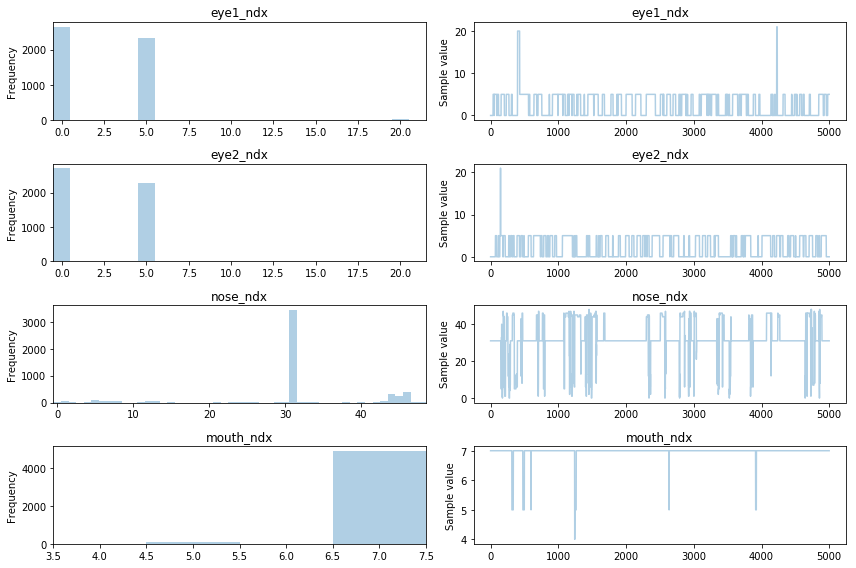

In [7]:
with face_detector:
    tr = pm.sample(draws=5000, tune=1000, chains=1)
    if use_potentials:
        _ = pm.traceplot(tr, [eye1_ndx, eye2_ndx, nose_ndx, mouth_ndx, tension])
    else:
        _ = pm.traceplot(tr, [eye1_ndx, eye2_ndx, nose_ndx, mouth_ndx])        

Let us examine a few examples from the MCMC trace.

- If the potentials are not switched on, you should be able to see assignments where both eyes are actually coincident.
- In the non-face example this will be very clear as it only actually has one eye.

In [8]:
tr[1], tr[2], tr[3], tr[4], tr[5], tr[6], tr[7], tr[8]

({'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31},
 {'eye1_ndx': 0, 'eye2_ndx': 0, 'mouth_ndx': 7, 'nose_ndx': 31})

In [9]:
import math

def compute_tension(vals):
    eye1_ndx, eye2_ndx, nose_ndx, mouth_ndx = vals['eye1_ndx'], vals['eye2_ndx'], vals['nose_ndx'], vals['mouth_ndx']
    eye1_x, eye1_y = eye1_ndx%6, eye1_ndx//6
    eye2_x, eye2_y = eye2_ndx%6, eye2_ndx//6
    nose_x, nose_y = nose_ndx%7, nose_ndx//7
    mouth_x, mouth_y = 0, mouth_ndx
    
    # compute "configuration tension" 
    a = 0.5 * math.fabs((eye2_x-eye1_x)**2 + (eye1_y-eye2_y)**2 - 25)
    b = 0.5 * math.fabs((nose_x-eye1_x)**2 + (nose_y-eye1_y)**2 - 25)
    c = 0.5 * math.fabs((nose_x-eye2_x)**2 + (nose_y-eye2_y)**2 - 25)
    d = 0.5 * (mouth_y-nose_y-3)**2
    
    return a+b+c+d

# example from face 1
print('face 1 tension = %d' % compute_tension({'eye1_ndx': 0, 'eye2_ndx': 5, 'mouth_ndx': 7, 'nose_ndx': 31}))
# example from face 2
print('face 2 tension = %d' % compute_tension({'eye1_ndx': 0, 'eye2_ndx': 11, 'mouth_ndx': 7, 'nose_ndx': 30}))
# example from non-face
print('non-face tension = %d' % compute_tension({'eye1_ndx': 5, 'eye2_ndx': 12, 'mouth_ndx': 5, 'nose_ndx': 37}))


face 1 tension = 2
face 2 tension = 6
non-face tension = 17


Note that the tension for face 1 is not 0, since the distance from the top-left corner of the nose to the top-left corner of the right eye is not 25, as it is to the top-left corner of the left eye.

### Visualization of potential terms
Let us examine what the potential terms look like geometrically to understand what conditions they impose.  Below we show the log-probability contribution of the potential.

As a term in the posterior, each potential is a term of the form:

$$\Psi(dx, dy) = \exp(-\frac{1}{2}(|dx^2 + dy^2| - 25)),$$

so the log-probability contribution is just

$$\log \Psi(dx, dy) = -\frac{1}{2}(|dx^2 + dy^2| - 25).$$

Text(0.5,1,'Eye-eye and eye-nose log-potentials')

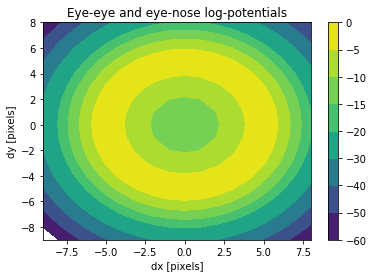

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

dx, dy = np.meshgrid(np.arange(-9, 9), np.arange(-9, 9))
dp = -0.5 * np.abs(dx**2 + dy**2 - 25)

cs = plt.contourf(dx,dy, dp, levels = [-60, -50, -40, -30, -20, -15, -10, -5, 0])
plt.colorbar()
plt.xlabel('dx [pixels]')
_ = plt.ylabel('dy [pixels]')
plt.title('Eye-eye and eye-nose log-potentials')

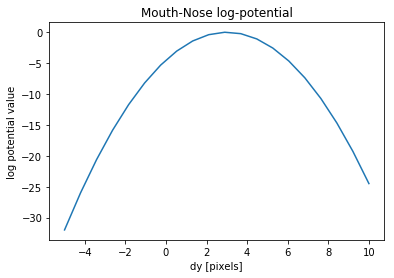

In [11]:
dy = np.linspace(-5, 10, 20)
plt.plot(dy, -0.5*(dy-3)**2)
plt.title('Mouth-Nose log-potential')
plt.xlabel('dy [pixels]')
_ = plt.ylabel('log potential value')

## Conclusions

The factor potential is one of the building blocks of Bayesian models. Factor potentials can establish a structure in the model output and thus eliminate predictions which are not compatible with expectations or constrained. Conceptually, factor potentials introduce a symmetric term (corresponding to an undirected link in the model graph) into the posterior while hierarchical Bayesian terms correspond do directed relationships.

We have studied the effect of factor potentials on the problem of 'face detection' and shown how using factor potential eliminates degenerate solutions such as both eye detectors locking on the same eye.